# BPM Prediction Challenge

The objective of this project is to predict the tempo of a music track, expressed in Beats Per Minute (BPM), based on a set of audio-related features.

This task is closely related to what professional DJ software such as Rekordbox performs in practice: automatically analyzing audio tracks to extract tempo, energy, and structural information, which is then used for beat matching, track synchronization, and playlist preparation.

By learning the relationship between BPM and musical characteristics such as rhythm, energy, loudness, and mood, this project aims to replicate the core tempo estimation logic used in modern music analysis tools.

## Competition Objective
The objective of this competition is to predict the tempo of music tracks, expressed in Beats Per Minute (BPM), using a set of audio-related features. Model performance is evaluated using the Root Mean Square Error (RMSE), which measures the average deviation between predicted and actual BPM values.

## Importation of the librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from scipy import stats
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from IPython.display import display, HTML
import io
import base64

sns.set_theme(style="whitegrid")

np.random.seed(42)

## Loading data

In [2]:
df = pd.read_csv("C:\\Users\\alexl\\Downloads\\train.csv")
print(df.head())

features = [
    "RhythmScore", "AudioLoudness", "VocalContent",
    "AcousticQuality", "InstrumentalScore",
    "LivePerformanceLikelihood", "MoodScore",
    "TrackDurationMs", "Energy"
]
target = "BeatsPerMinute"

   id  RhythmScore  AudioLoudness  VocalContent  AcousticQuality  \
0   0     0.603610      -7.636942      0.023500         0.000005   
1   1     0.639451     -16.267598      0.071520         0.444929   
2   2     0.514538     -15.953575      0.110715         0.173699   
3   3     0.734463      -1.357000      0.052965         0.001651   
4   4     0.532968     -13.056437      0.023500         0.068687   

   InstrumentalScore  LivePerformanceLikelihood  MoodScore  TrackDurationMs  \
0           0.000001                   0.051385   0.409866      290715.6450   
1           0.349414                   0.170522   0.651010      164519.5174   
2           0.453814                   0.029576   0.423865      174495.5667   
3           0.159717                   0.086366   0.278745      225567.4651   
4           0.000001                   0.331345   0.477769      213960.6789   

     Energy  BeatsPerMinute  
0  0.826267       147.53020  
1  0.145400       136.15963  
2  0.624667        55.3198

**Feature Description with musical genre examples**

**RhythmScore** measures the clarity and regularity of rhythmic patterns.

- High values: Electronic Dance Music (EDM), Techno, House
- Low values: Ambient, Classical, Jazz ballads

**AudioLoudness** represents the overall perceived loudness of a track.

- High values: Rock, Metal, EDM
- Low values: Acoustic Folk, Classical, Jazz

Louder tracks are often associated with higher energy and faster tempos, although this is not always strictly true.

**VocalContent** quantifies the presence of vocals in the track.

- High values: Pop, Rap, R&B
- Low values: Techno, Classical, Instrumental Jazz

Vocal-heavy genres often show more moderate BPMs, while instrumental electronic genres tend to push tempo boundaries.

**AcousticQuality** indicates how acoustic or organic a track sounds.

- High values: Folk, Classical, Singer-songwriter
- Low values: EDM, Techno, Synthwave

Acoustic music often exhibits natural tempo variations, whereas electronic genres typically maintain a very stable BPM, which simplifies tempo detection.

**InstrumentalScore** measures the absence of vocals.

- High values: Techno, Classical, Soundtracks
- Low values: Pop, Hip-Hop, R&B

Instrumental tracks frequently rely on rhythm and tempo to drive the musical structure, making BPM a key defining attribute.

**LivePerformanceLikelihood** estimates the probability that a track was recorded live.

- High values: Live Rock, Jazz concerts
- Low values: Studio EDM, Pop productions

Live recordings often include tempo fluctuations caused by human performance, making BPM estimation more challenging compared to studio-produced electronic tracks.

**MoodScore** captures the emotional tone of the track.

- High values (uplifting / energetic): EDM, Pop, Dance
- Low values (calm / melancholic): Ambient, Classical, Downtempo

Mood and tempo are strongly correlated: high-energy moods usually align with higher BPMs.

**TrackDurationMs** represents the total duration of the track.

- Short tracks: Pop, Radio edits
- Long tracks: Techno, Progressive House, Classical movements

While BPM is independent of duration in theory, club-oriented genres often feature longer tracks with stable tempos optimized for mixing — exactly the type of structure analyzed by DJ software like Rekordbox.

**Energy** measures the overall intensity and activity level of the track.

- High values: Techno, Drum & Bass, Hardstyle
- Low values: Ambient, Classical, Chillout

Energy is one of the most informative predictors of BPM, as fast and rhythm-driven genres typically exhibit both high energy and high tempo.

## Data analysis and exploration
 

         RhythmScore  AudioLoudness   VocalContent  AcousticQuality  \
count  524164.000000  524164.000000  524164.000000    524164.000000   
mean        0.632843      -8.379014       0.074443         0.262913   
std         0.156899       4.616221       0.049939         0.223120   
min         0.076900     -27.509725       0.023500         0.000005   
25%         0.515850     -11.551933       0.023500         0.069413   
50%         0.634686      -8.252499       0.066425         0.242502   
75%         0.739179      -4.912298       0.107343         0.396957   
max         0.975000      -1.357000       0.256401         0.995000   

       InstrumentalScore  LivePerformanceLikelihood      MoodScore  \
count      524164.000000              524164.000000  524164.000000   
mean            0.117690                   0.178398       0.555843   
std             0.131845                   0.118186       0.225480   
min             0.000001                   0.024300       0.025600   
25%       

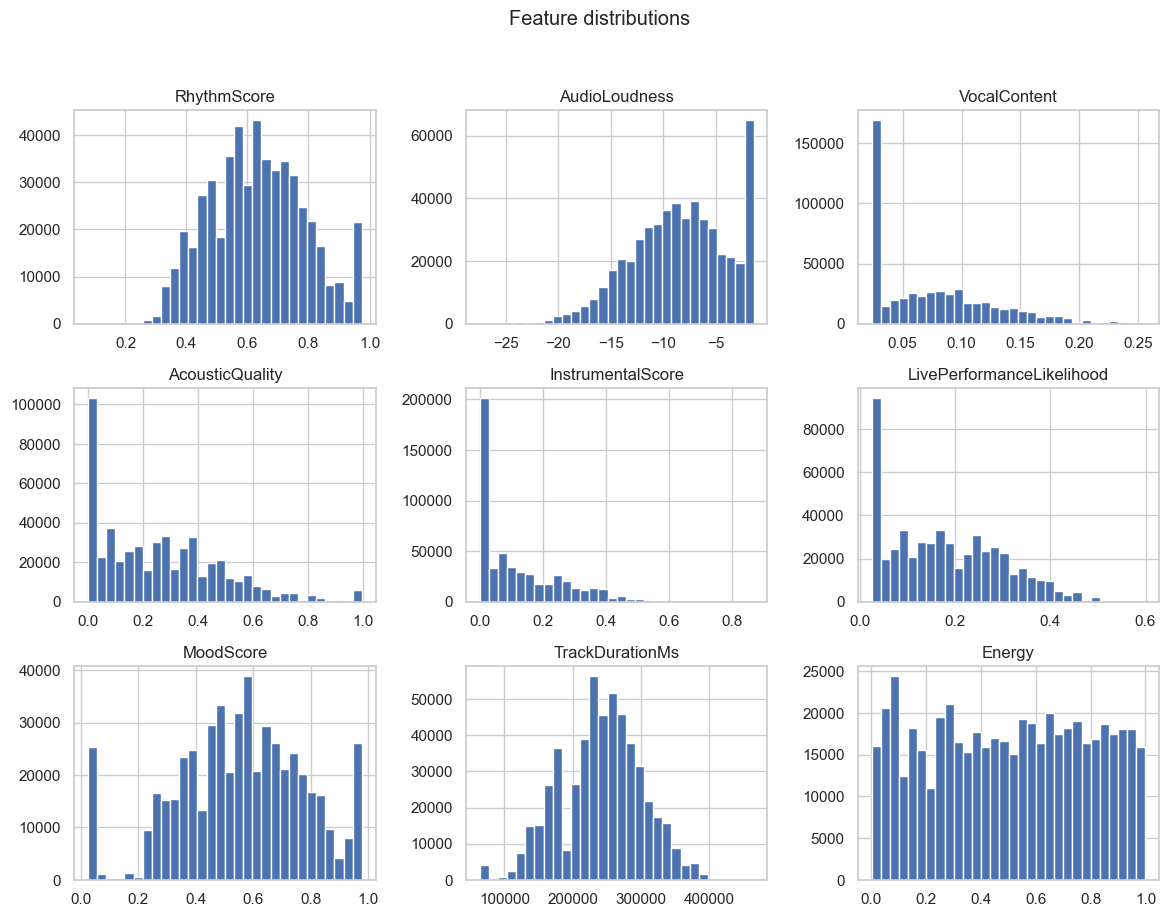

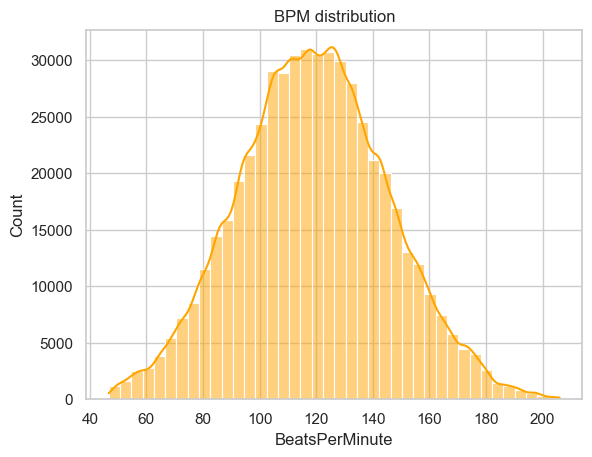

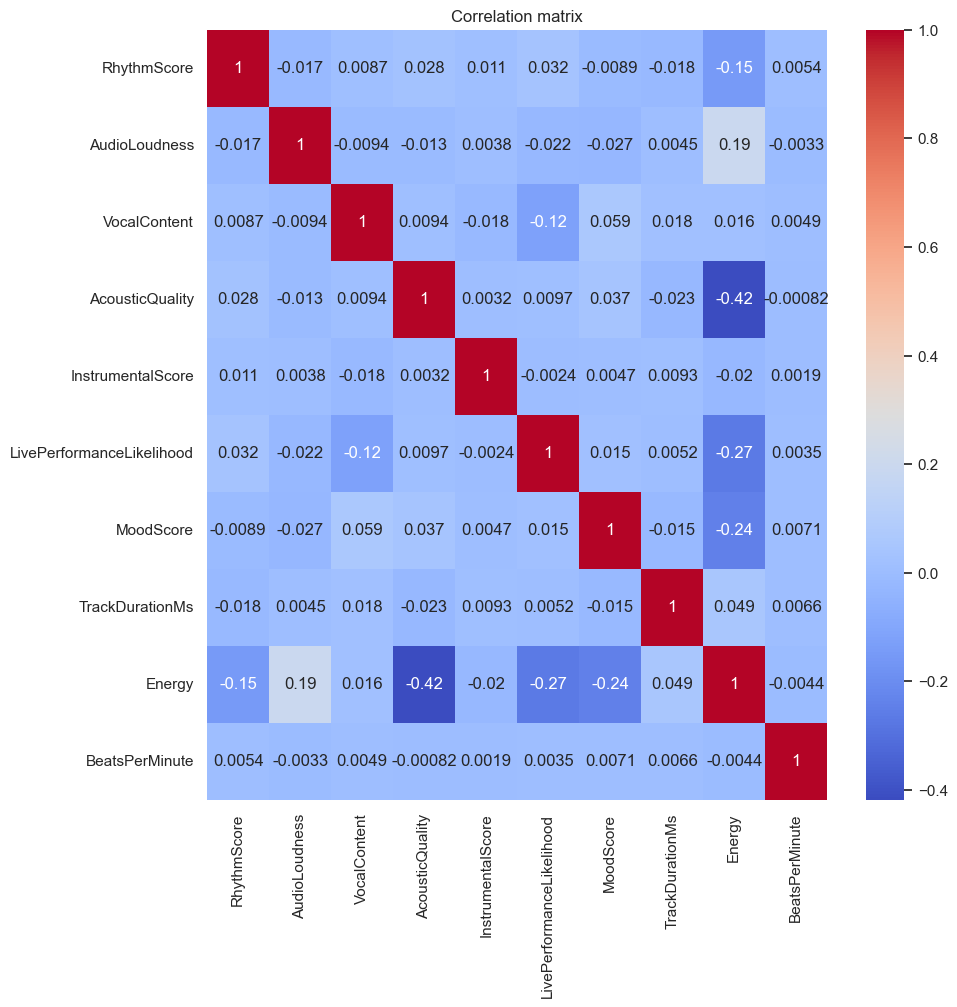


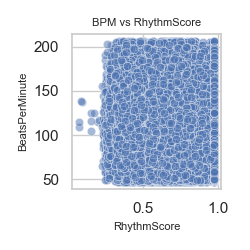
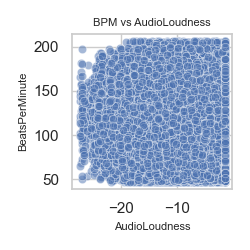
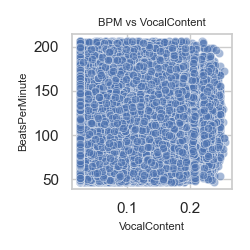
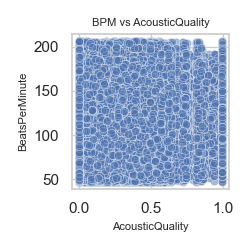
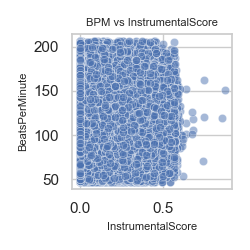
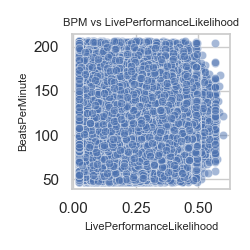
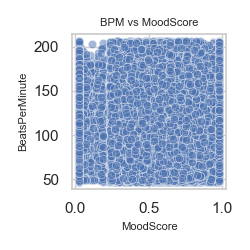
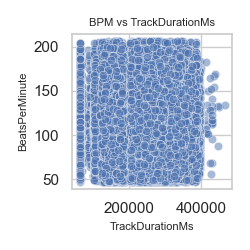
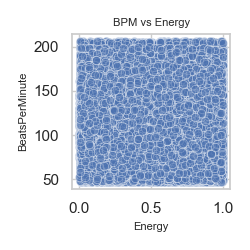

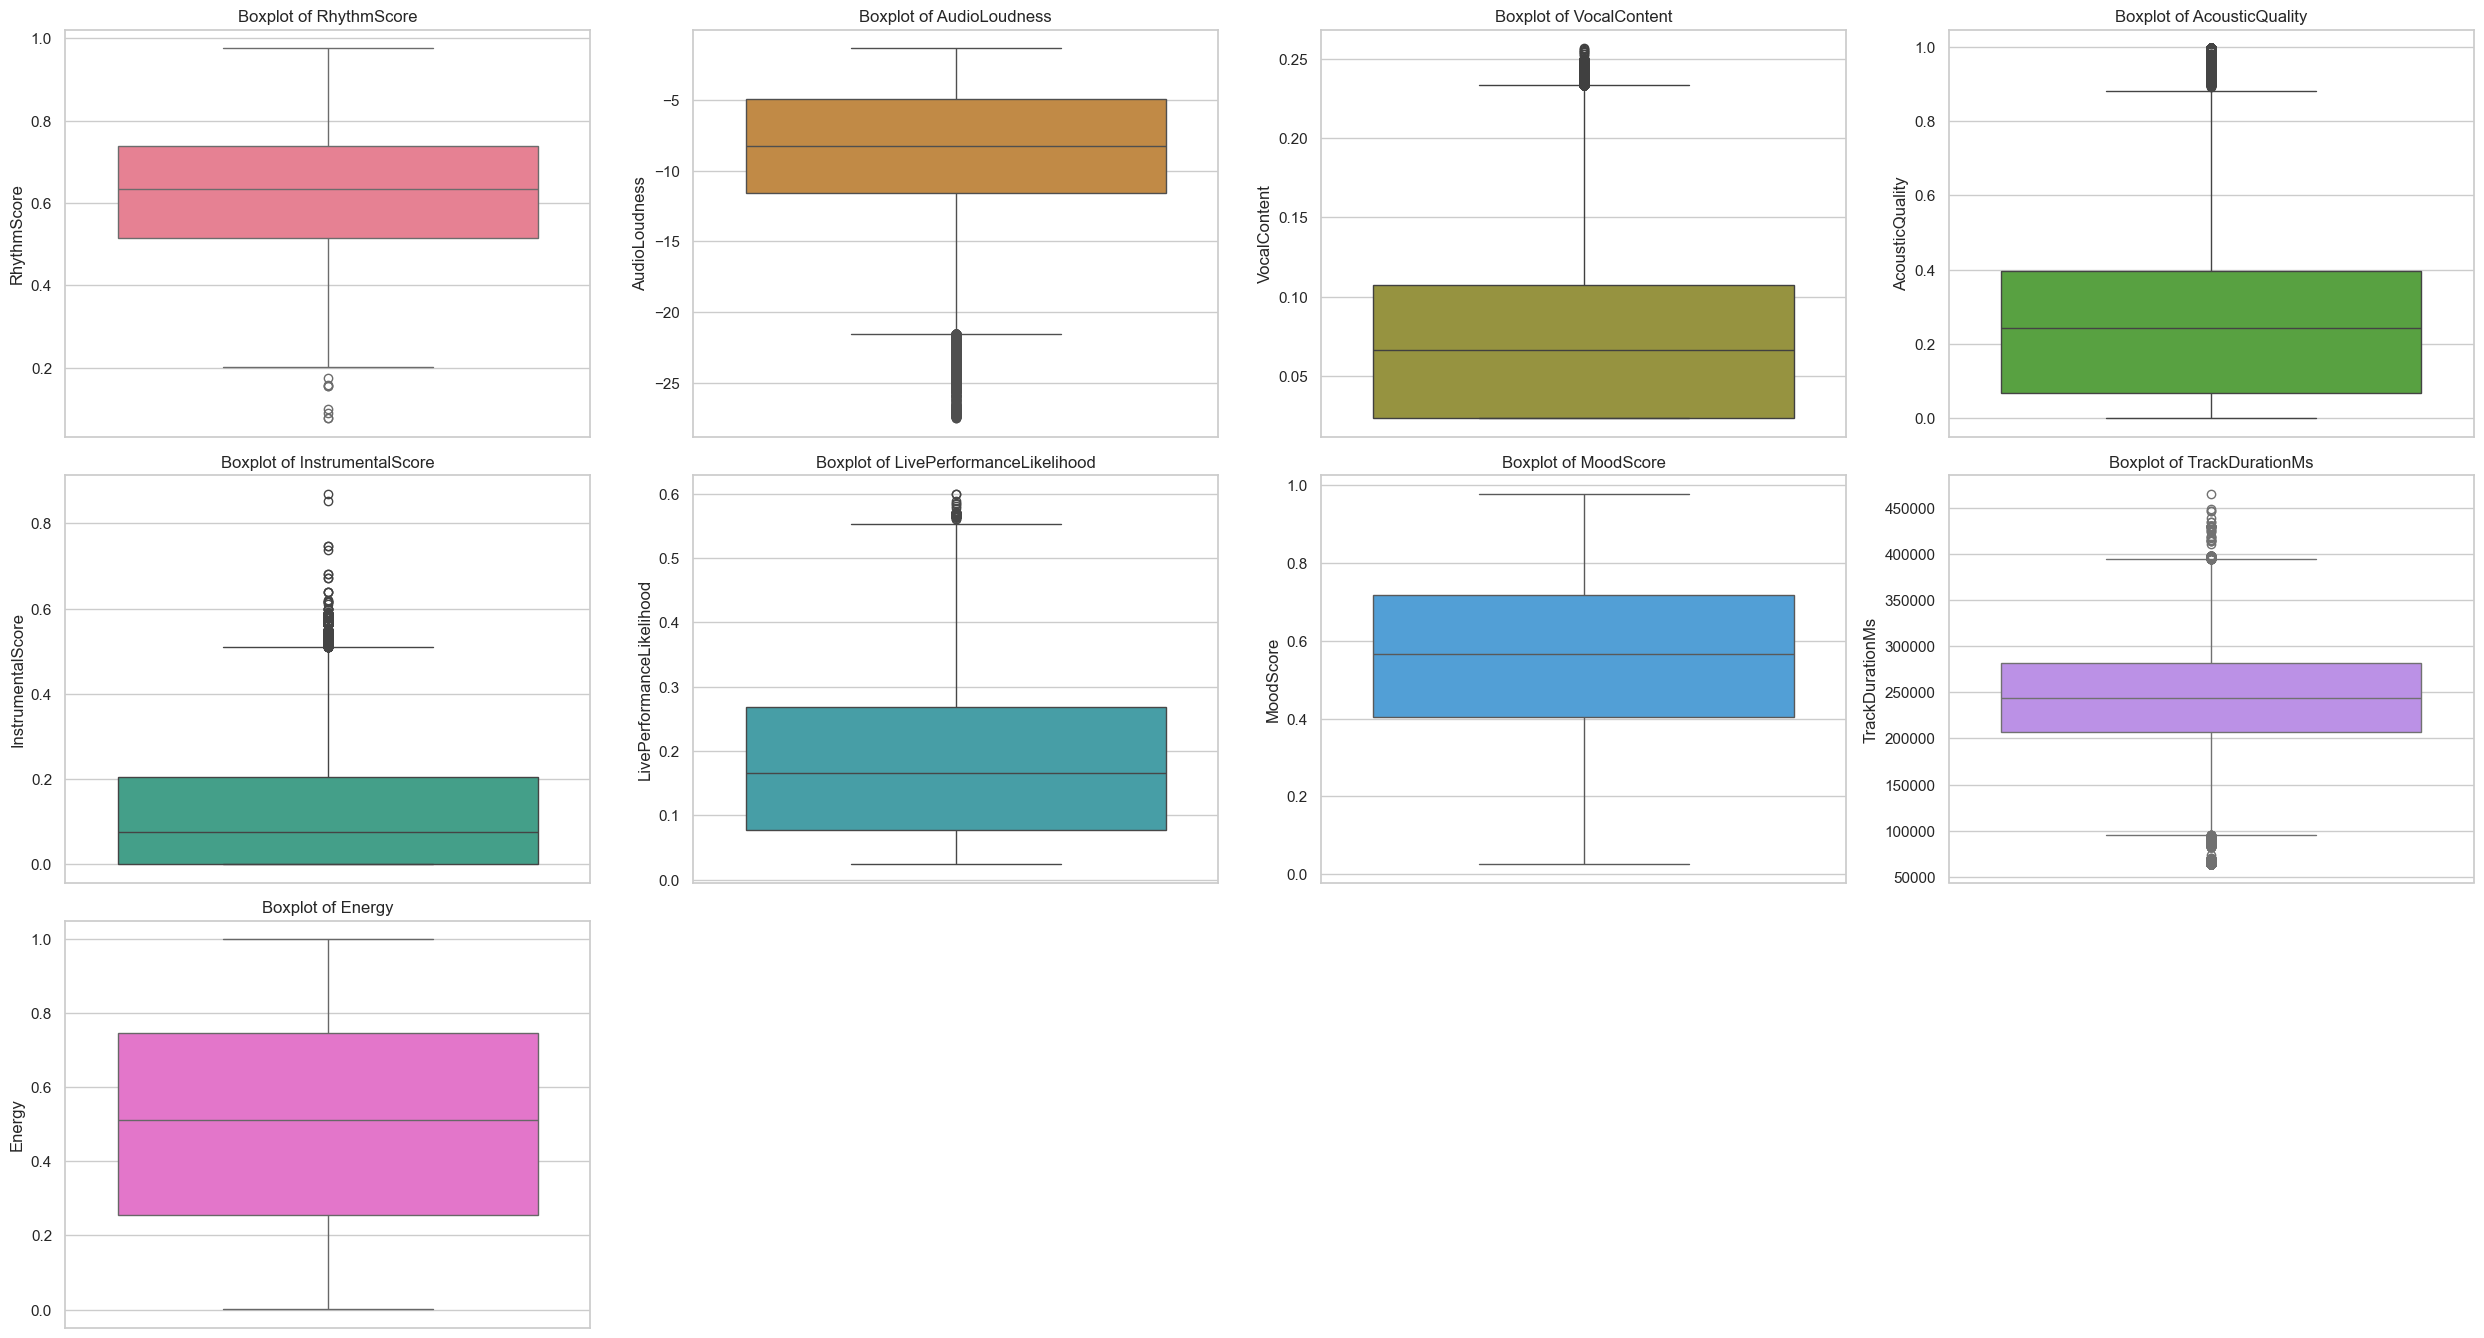

In [3]:
print(df[features + [target]].describe())

# Missing values check
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0])

# Quick summary statistics (outlier detection)
print("\nSummary statistics:")
print(df.describe())

# Outlier detection using IQR
print("\nPotential outliers (IQR method):")
for col in features + [target]:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    print(f"{col}: {outliers} potential outliers")


# Distribution features
df[features].hist(figsize=(14,10), bins=30)
plt.suptitle("Feature distributions")
plt.show()

# Distribution target
sns.histplot(df[target], bins=40, kde=True, color='orange')
plt.title("BPM distribution")
plt.show()

# Correlation matrix
plt.figure(figsize=(10,10))
sns.heatmap(df[features + [target]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation matrix")
plt.show()

# Scatter plots BPM vs features
html_str = ""

for f in features:
    plt.figure(figsize=(2.5,2.5))  
    sns.scatterplot(x=df[f], y=df[target], alpha=0.5)
    plt.title(f"BPM vs {f}", fontsize=8)
    plt.xlabel(f, fontsize=8)
    plt.ylabel(target, fontsize=8)
    plt.tight_layout()
    
    # We save the figure into a buffer for layout purpose
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    img_base64 = base64.b64encode(buf.read()).decode('utf-8')
    buf.close()
    plt.close()
    html_str += f'<img src="data:image/png;base64,{img_base64}" style="margin:2px;">'

display(HTML(html_str))

# Boxplots des features
palette = sns.color_palette("husl", len(features))
plt.figure(figsize=(25, 18))
for i, col in enumerate(features, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(y=df[col], color=palette[i-1])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

The correlation matrix shows that BeatsPerMinute (BPM) has almost no linear correlation with any individual feature. All correlation coefficients are close to zero, suggesting that BPM cannot be explained by simple linear relationships alone.

However, several features exhibit moderate correlations among themselves (e.g. Energy with AcousticQuality or LivePerformanceLikelihood), indicating that the feature set is musically coherent but potentially redundant.

Despite these observations, linear models will still be tested in the next steps in order to empirically confirm the limitations suggested by the correlation analysis.

## Data Scaling

In [4]:
X = df[features]
y = df[target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Principal Component Analysis

Before training predictive models, applying Principal Component Analysis (PCA) is useful to better understand the structure of the feature space:
It helps identify redundant or highly correlated features and reveals the main axes of variability in the data.
Moreover, it provides insight into whether BPM may be influenced by combinations of features rather than individual ones.

PCA is therefore used as an exploratory tool, not as a replacement for the original features, to guide model selection and interpretation.


Top features contributing to PC1:
Energy                       0.684066
AudioLoudness                0.242814
TrackDurationMs              0.080638
VocalContent                 0.039853
InstrumentalScore           -0.026385
RhythmScore                 -0.197974
MoodScore                   -0.298252
LivePerformanceLikelihood   -0.321847
AcousticQuality             -0.482260
Name: PC1, dtype: float64

Top features contributing to PC2:
VocalContent                 0.712316
MoodScore                    0.359647
AcousticQuality              0.171995
TrackDurationMs             -0.002156
Energy                      -0.019851
RhythmScore                 -0.050411
InstrumentalScore           -0.073451
AudioLoudness               -0.075398
LivePerformanceLikelihood   -0.565383
Name: PC2, dtype: float64


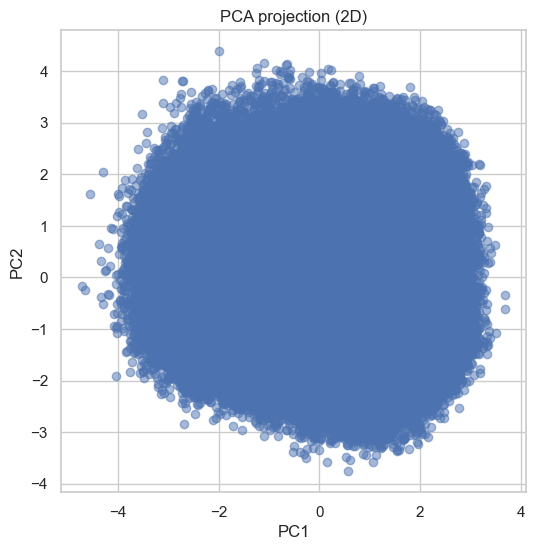

<Figure size 800x500 with 0 Axes>

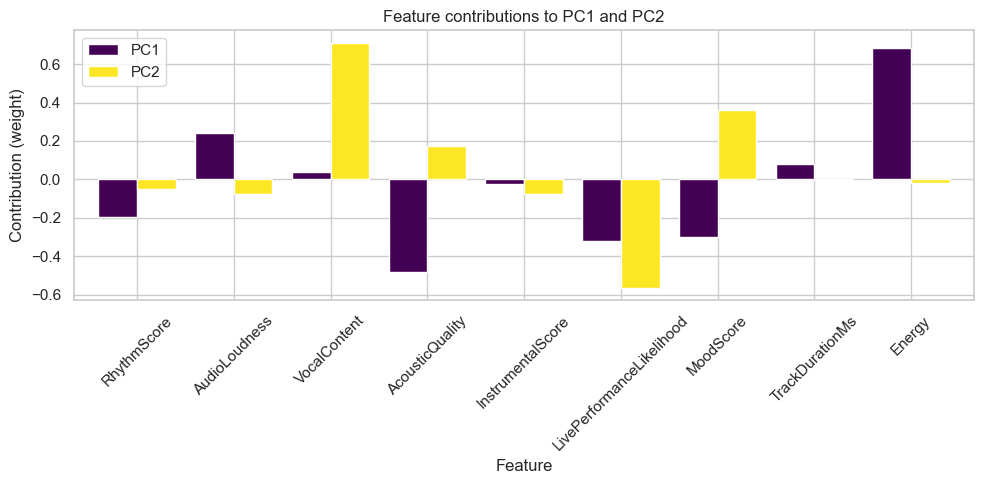

In [5]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_components = pd.DataFrame(
    pca.components_,      
    columns=features,     
    index=['PC1','PC2']
)

for pc in ['PC1','PC2']:
    print(f"\nTop features contributing to {pc}:")
    print(pca_components.loc[pc].sort_values(ascending=False))

# Scatter plot PCA
plt.figure(figsize=(6,6))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.5)
plt.title("PCA projection (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

df_plot = pca_components.T

plt.figure(figsize=(8,5))
df_plot.plot(kind='bar', figsize=(10,5), width=0.8, colormap='viridis')
plt.title("Feature contributions to PC1 and PC2")
plt.ylabel("Contribution (weight)")
plt.xlabel("Feature")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Clustering

In addition, a clustering analysis is performed on the transformed feature space. The goal is to identify natural groupings of tracks that may correspond to different musical styles or production characteristics. Analyzing how BPM is distributed across these clusters helps determine whether tempo is better explained at a group level rather than through direct feature-to-BPM relationships.

### Model 1: K-means

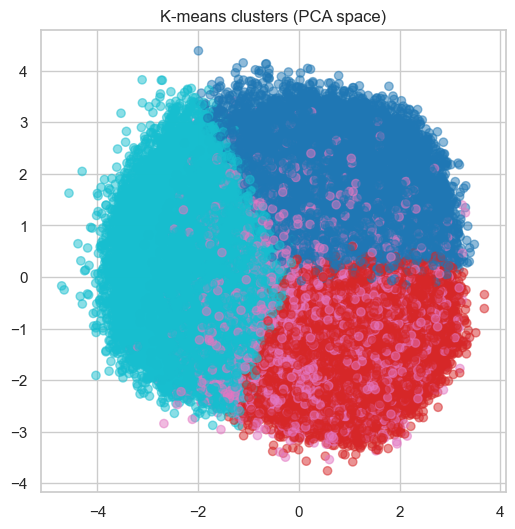

In [6]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df['cluster_kmeans'] = clusters

plt.figure(figsize=(6,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap='tab10', alpha=0.5)
plt.title("K-means clusters (PCA space)")
plt.show()

### Model 2: GMM

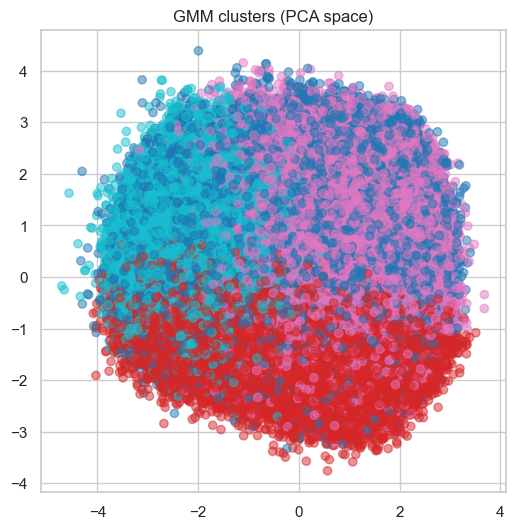

In [7]:
gmm = GaussianMixture(n_components=k, random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)
df['cluster_gmm'] = gmm_labels

plt.figure(figsize=(6,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=gmm_labels, cmap='tab10', alpha=0.5)
plt.title("GMM clusters (PCA space)")
plt.show()

None

In [8]:
print(df.groupby('cluster_kmeans')[features].mean())
print(df.groupby('cluster_kmeans')['BeatsPerMinute'].describe())



# Average BPM per cluster
print("Average BPM per cluster:")
print(df.groupby('cluster_kmeans')[target].mean())

                RhythmScore  AudioLoudness  VocalContent  AcousticQuality  \
cluster_kmeans                                                              
0                  0.617572      -7.640618      0.122400         0.223539   
1                  0.615796      -7.425207      0.043867         0.144655   
2                  0.637892      -7.739424      0.065004         0.217391   
3                  0.659635     -10.364995      0.070668         0.443707   

                InstrumentalScore  LivePerformanceLikelihood  MoodScore  \
cluster_kmeans                                                            
0                        0.067243                   0.089895   0.585791   
1                        0.052740                   0.206809   0.453603   
2                        0.330633                   0.168036   0.547722   
3                        0.090385                   0.231109   0.638361   

                TrackDurationMs    Energy  
cluster_kmeans                            

The clustering reveals distinct audio profiles across clusters, mainly driven by differences in energy, acoustic quality, instrumental content, and loudness.

*Cluster 0 & 1*
These two clusters are quite similar: 
- High Energy and RhythmScore
- Low AcousticQuality
- Relatively loud tracks
→ Likely studio-produced, rhythm-driven tracks, typical of pop or electronic-oriented music.

*Cluster 2*
- Lower Energy
- Significantly higher InstrumentalScore
- Moderate AcousticQuality
→ More instrumental and less aggressive tracks, possibly soundtracks or electronic instrumental music.

*Cluster 3*
- Very low Energy
- High AcousticQuality
- Louder dynamics (lower loudness compression)
- Higher MoodScore
→ Likely acoustic or calm music, such as folk, classical, or ambient tracks.



Despite these clear differences in audio characteristics, the average BPM is almost identical across clusters (≈119 BPM), with very similar distributions and standard deviations.

The clustering captures musical style and production characteristics but tempo is not strongly differentiated at the cluster level.

## Linear regression

### Model 1: Linear regression with all variables

In [9]:

X_df = pd.DataFrame(X, columns=features)
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)
X_train_sm = sm.add_constant(X_train)
model_1 = sm.OLS(y_train, X_train_sm).fit()

model_1.features_ = features

print(model_1.summary()) 

X_test_sm = sm.add_constant(X_test)
y_pred_mod1 = model_1.predict(X_test_sm)

# RMSE
rmse_mod1 = np.sqrt(np.mean((y_test - y_pred_mod1)**2))
print(f"RMSE : {rmse_mod1:.4f}")

                            OLS Regression Results                            
Dep. Variable:         BeatsPerMinute   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     8.635
Date:                Sun, 08 Feb 2026   Prob (F-statistic):           4.60e-13
Time:                        22:56:28   Log-Likelihood:            -1.9688e+06
No. Observations:              419331   AIC:                         3.938e+06
Df Residuals:                  419321   BIC:                         3.938e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

Given the limited performance of the full linear model and the presence of multicollinearity, a second linear regression is fitted using only the most explanatory variables identified in the previous analysis. The objective is to assess whether restricting the model to statistically significant features improves interpretability and predictive performance, while reducing noise and redundancy in the feature set.

### Model 2: Linear regression with explanatory variables

In [10]:
features_mod2 = features
X_orig_df = pd.DataFrame(X, columns=features_mod2) 

# Select only significant variables
significant_features = ['RhythmScore','VocalContent','MoodScore','TrackDurationMs']
X_df = X_orig_df[significant_features]  

X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)

X_train_sm = sm.add_constant(X_train)
model_2 = sm.OLS(y_train, X_train_sm).fit()

model_2.features_ = significant_features

print("\n Regression with significant variables")
print(model_2.summary())  

X_test_sm = sm.add_constant(X_test)
y_pred_mod2 = model_2.predict(X_test_sm)

# RMSE
rmse_mod2 = np.sqrt(np.mean((y_test - y_pred_mod2)**2))
print(f"RMSE: {rmse_mod2:.4f}")


 Regression with significant variables
                            OLS Regression Results                            
Dep. Variable:         BeatsPerMinute   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     16.64
Date:                Sun, 08 Feb 2026   Prob (F-statistic):           1.22e-13
Time:                        22:56:29   Log-Likelihood:            -1.9688e+06
No. Observations:              419331   AIC:                         3.938e+06
Df Residuals:                  419326   BIC:                         3.938e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
co

Given the limited performance of linear models using raw features, a third model is built after applying feature engineering. The goal is to enrich the feature space by capturing interactions and non-linear effects between audio characteristics that may better reflect how tempo emerges from combinations of musical attributes. This approach aims to provide linear models with more informative inputs and to assess whether engineered features can improve BPM prediction before moving to fully non-linear models.

### Feature Engineering for Linear Regression

In [11]:
base_features = ['RhythmScore', 'VocalContent', 'MoodScore', 'TrackDurationMs', 'Energy', 'AcousticQuality']

X_df = pd.DataFrame(X, columns=features)
X_fe = X_df[base_features].copy()

# Relevant interactions
X_fe['Energy_x_Acoustic'] = X_fe['Energy'] * X_fe['AcousticQuality']
X_fe['Mood_x_Vocal'] = X_fe['MoodScore'] * X_fe['VocalContent']

# Nonlinear terms
X_fe['Rhythm2'] = X_fe['RhythmScore'] ** 2
X_fe['Mood2'] = X_fe['MoodScore'] ** 2

# Clustering-related features (non standardised)
if 'cluster_kmeans' in df.columns:
    cluster_dummies = pd.get_dummies(df['cluster_kmeans'], prefix='cluster', drop_first=True)
    X_fe = pd.concat([X_fe, cluster_dummies], axis=1)

if 'dist_to_centroid' in df.columns:
    X_fe['dist_to_centroid'] = df['dist_to_centroid']

# Standardisation
cols_to_scale = [
    'RhythmScore', 'VocalContent', 'MoodScore', 'TrackDurationMs',
    'Energy', 'AcousticQuality',
    'Energy_x_Acoustic', 'Mood_x_Vocal',
    'Rhythm2', 'Mood2'
]

scaler = StandardScaler()
X_fe[cols_to_scale] = scaler.fit_transform(X_fe[cols_to_scale])

print("Shape after feature engineering:", X_fe.shape)
X_fe.head()

Shape after feature engineering: (524164, 13)


,RhythmScore,VocalContent,MoodScore,TrackDurationMs,Energy,AcousticQuality,Energy_x_Acoustic,Mood_x_Vocal,Rhythm2,Mood2,cluster_1,cluster_2,cluster_3
0,-0.186320,-1.020114,-0.647405,0.822767,1.122062,-1.178322,-0.864100,-0.916845,-0.296589,-0.778017,True,False,False
1,0.042116,-0.058541,0.422064,-1.304377,-1.226143,0.815779,-0.329917,0.127894,-0.079122,0.259639,False,False,True
2,-0.754022,0.726325,-0.585321,-1.136222,0.426774,-0.399847,0.031866,0.138307,-0.782723,-0.730677,False,True,False
3,0.647674,-0.430095,-1.228925,-0.275361,-0.046407,-1.170947,-0.857491,-0.771661,0.558041,-1.144251,True,False,False
4,-0.636554,-1.020114,-0.346257,-0.471004,1.539602,-0.870498,-0.326806,-0.871700,-0.688488,-0.533542,True,False,False


### Model 3: Linear regression with feature engineering

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_fe, y, test_size=0.2, random_state=42)

X_train_sm = sm.add_constant(X_train).astype(float)
X_test_sm = sm.add_constant(X_test).astype(float)
model_3 = sm.OLS(y_train, X_train_sm).fit()
model_3.features_ = X_train.columns.tolist() 

print("\n Linear regression with feature engineering :")
print(model_3.summary())

X_test_sm = sm.add_constant(X_test)

y_pred_mod3 = model_3.predict(X_test_sm)

# RMSE
rmse_mod3 = np.sqrt(np.mean((y_test - y_pred_mod3)**2))
print(f"RMSE : {rmse_mod3:.4f}")


 Linear regression with feature engineering :
                            OLS Regression Results                            
Dep. Variable:         BeatsPerMinute   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     7.110
Date:                Sun, 08 Feb 2026   Prob (F-statistic):           4.80e-14
Time:                        22:56:30   Log-Likelihood:            -1.9688e+06
No. Observations:              419331   AIC:                         3.938e+06
Df Residuals:                  419317   BIC:                         3.938e+06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

The linear regression model trained on engineered features does not yield a significant improvement in predictive performance, with the test RMSE remaining close to 26.4. Although a small number of coefficients remain weakly significant, most interaction terms do not contribute meaningfully to the model. This suggests that a single global linear model is unable to capture the complexity of BPM prediction. Consequently, the next step consists in fitting separate linear regression models for each cluster, in order to assess whether cluster-specific relationships between audio features and tempo can be better captured within more homogeneous subsets of tracks. In this setting, residuals are explicitly analyzed to better understand the remaining sources of error, detect systematic biases, and identify patterns that are not explained by the linear models.

### Residual studies and prediction results

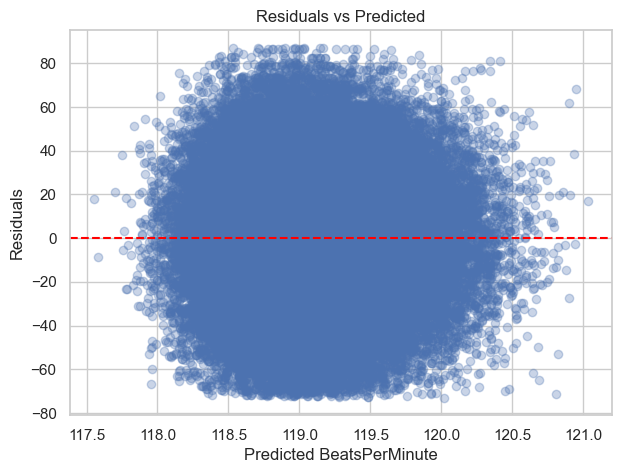

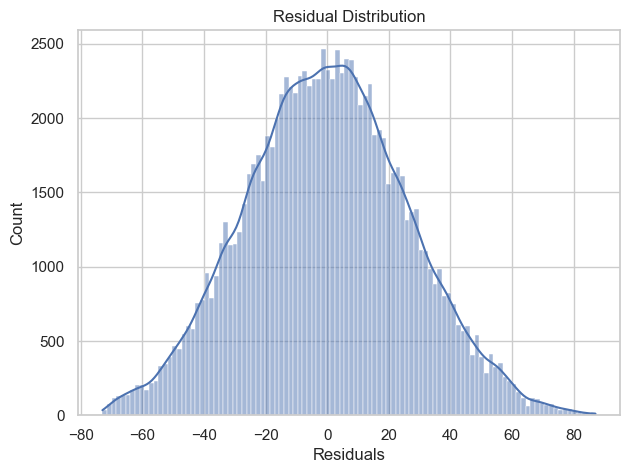

<Figure size 600x600 with 0 Axes>

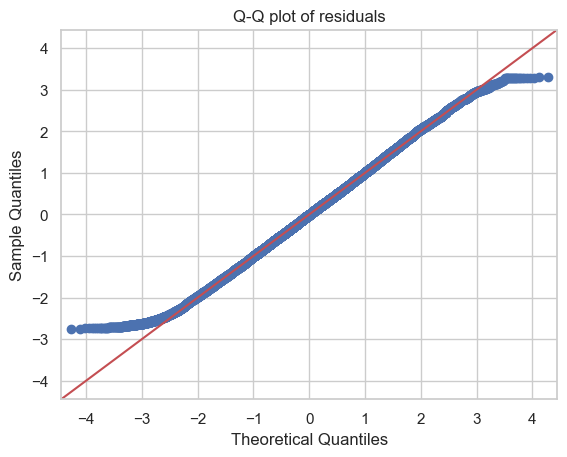


Sorted coefficients:
Rhythm2               -0.549984
MoodScore             -0.284692
AcousticQuality       -0.172995
Energy                -0.060661
Energy_x_Acoustic      0.078903
VocalContent           0.097361
Mood_x_Vocal           0.137253
TrackDurationMs        0.165020
cluster_1              0.219016
cluster_2              0.254976
Mood2                  0.406427
cluster_3              0.430492
RhythmScore            0.684783
const                118.823469
dtype: float64


In [13]:
y_pred = model_3.predict(X_test_sm)
residuals = y_test - y_pred

# Residuals vs Predicted
plt.figure(figsize=(7,5))
plt.scatter(y_pred, residuals, alpha=0.3)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel('Predicted BeatsPerMinute')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.show()

# Residual histogram
plt.figure(figsize=(7,5))
sns.histplot(residuals, kde=True)
plt.title('Residual Distribution')
plt.xlabel('Residuals')
plt.show()

# Q-Q plot of residuals
residuals = np.array(residuals, dtype=float)  
residuals = residuals[np.isfinite(residuals)]  

# Q-Q plot
plt.figure(figsize=(6,6))
sm.qqplot(residuals, line='45', fit=True)  # line='45' trace la ligne y=x
plt.title("Q-Q plot of residuals")
plt.grid(True)
plt.show()



# Sorted coefficients 
print("\nSorted coefficients:")
print(model_3.params.sort_values())


The overall linear model shows that certain variables influence BPM, but it remains limited and captures only a small portion of the variance, resulting in noisy residuals. The Q-Q plot confirms that the residuals are generally normal, but the dispersion around the predictions reveals nonlinear effects or effects specific to certain types of songs. To better understand the influence of clusters, it is useful to perform separate regressions for each cluster: this allows us to identify the relationships specific to each group and compare the contribution of the variables, while assessing whether certain clusters are better explained than others by the linear model.

### Model 4: Linear regressions on each cluster with feature engineering

In [14]:
features_to_use = [col for col in X_fe.columns if not col.startswith('cluster')]

clusters = df['cluster_kmeans'].unique()
y_pred_list = []
rmse_list = []
weights = []

for c in clusters:
    mask = df['cluster_kmeans'] == c
    X_c = X_fe.loc[mask, features_to_use]
    y_c = y[mask]

    X_train, X_test, y_train, y_test = train_test_split(
        X_c, y_c, test_size=0.2, random_state=42
    )

    X_train_sm = sm.add_constant(X_train).astype(float)
    X_test_sm = sm.add_constant(X_test).astype(float)
    model_4 = sm.OLS(y_train, X_train_sm).fit()
    model_4.features_ = X_train_sm.columns.tolist()

    y_pred_c = model_4.predict(X_test_sm)
    rmse_c = np.sqrt(mean_squared_error(y_test, y_pred_c))

    y_pred_list.append(y_pred_c)
    rmse_list.append(rmse_c)
    weights.append(len(y_test)) 


# RMSE global pondéré
rmse_mod4 = np.sqrt(np.average(np.array(rmse_list)**2, weights=weights))
print(f"RMSE pondéré Modèle 4: {rmse_mod4:.4f}")

# Pour créer y_pred global pondéré, concatène d'abord toutes les prédictions
y_pred_mod4 = np.concatenate(y_pred_list)

RMSE pondéré Modèle 4: 26.5042


Cluster segmentation does not significantly improve the overall error of the linear model, but it does highlight the specific relationships within each group of tracks, revealing local effects that are masked by the overall regression.

We will now attempt a final model using Ridge and Lasso regression. These regularized linear models can help address multicollinearity among features, shrink less important coefficients, and potentially improve generalization, while still providing interpretable coefficients for each variable. This approach may reduce overfitting and highlight which features are most relevant for predicting BPM, complementing the insights gained from the cluster-specific regressions.

### Model 5: Ridge and Lasso Regression 

In [15]:
# Explanatory features (without cluster columns)
features_to_use = [col for col in X_fe.columns if not col.startswith('cluster')]
alphas = [0.01, 0.1, 1.0, 10.0]
clusters = df['cluster_kmeans'].unique()

# For weighted overall RMSE and predictions
y_pred_ridge_all = {a: [] for a in alphas}
y_pred_lasso_all = {a: [] for a in alphas}
rmse_ridge_all = {a: [] for a in alphas}
rmse_lasso_all = {a: [] for a in alphas}
weights_all = []

for c in clusters:
    print(f"Cluster {c}")
    
    mask = df['cluster_kmeans'] == c
    X_c = X_fe.loc[mask, features_to_use]
    y_c = y[mask]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_c, y_c, test_size=0.2, random_state=42
    )
    
    weights_all.append(len(y_test)) 
    
    # RIDGE
    print("\n Ridge Regression")
    for a in alphas:
        model_5 = Ridge(alpha=a)
        model_5.features_ = X_train.columns.tolist()

        model_5.fit(X_train, y_train)
        y_pred = model_5.predict(X_test)
        
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        print(f"alpha={a:<5} | RMSE={rmse:.3f} | R²={r2:.4f}")
        
        # On stocke chaque array de prédictions dans la liste
        y_pred_ridge_all[a].append(y_pred)
        rmse_ridge_all[a].append(rmse)
    
    # LASSO
    print("\n Lasso Regression")
    for a in alphas:
        model_5 = Lasso(alpha=a, max_iter=5000)
        model_5.features_ = X_train.columns.tolist()
        
        model_5.fit(X_train, y_train)
        y_pred = model_5.predict(X_test)
    
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        n_nonzero = np.sum(model_5.coef_ != 0)
        
        print(f"alpha={a:<5} | RMSE={rmse:.3f} | R²={r2:.4f} | non-zero={n_nonzero}")
        
        y_pred_lasso_all[a].append(y_pred)
        rmse_lasso_all[a].append(rmse)

# Weighted overall RMSE
weights_all = np.array(weights_all)

print("\n Cluster-weighted overall RMSE")

print("Ridge:")
for a in alphas:
    rmse_global_ridge = np.sqrt(np.average(np.array(rmse_ridge_all[a])**2, weights=weights_all))
    y_pred_global_ridge = np.concatenate(y_pred_ridge_all[a])
    
    print(f"alpha={a:<5} | Weighted overall RMSE = {rmse_global_ridge:.3f}")

print("\nLasso:")
for a in alphas:
    rmse_global_lasso = np.sqrt(np.average(np.array(rmse_lasso_all[a])**2, weights=weights_all))
    y_pred_global_lasso = np.concatenate(y_pred_lasso_all[a])
    print(f"alpha={a:<5} | Weighted overall RMSE = {rmse_global_lasso:.3f}")

Cluster 1

 Ridge Regression
alpha=0.01  | RMSE=26.602 | R²=-0.0002
alpha=0.1   | RMSE=26.602 | R²=-0.0002
alpha=1.0   | RMSE=26.602 | R²=-0.0002
alpha=10.0  | RMSE=26.602 | R²=-0.0002

 Lasso Regression
alpha=0.01  | RMSE=26.601 | R²=-0.0001 | non-zero=7
alpha=0.1   | RMSE=26.601 | R²=-0.0001 | non-zero=2
alpha=1.0   | RMSE=26.601 | R²=-0.0001 | non-zero=0
alpha=10.0  | RMSE=26.601 | R²=-0.0001 | non-zero=0
Cluster 3

 Ridge Regression
alpha=0.01  | RMSE=26.325 | R²=0.0001
alpha=0.1   | RMSE=26.325 | R²=0.0001
alpha=1.0   | RMSE=26.325 | R²=0.0001
alpha=10.0  | RMSE=26.325 | R²=0.0001

 Lasso Regression
alpha=0.01  | RMSE=26.323 | R²=0.0002 | non-zero=8
alpha=0.1   | RMSE=26.324 | R²=0.0002 | non-zero=5
alpha=1.0   | RMSE=26.326 | R²=-0.0000 | non-zero=0
alpha=10.0  | RMSE=26.326 | R²=-0.0000 | non-zero=0
Cluster 2

 Ridge Regression
alpha=0.01  | RMSE=26.375 | R²=-0.0005
alpha=0.1   | RMSE=26.375 | R²=-0.0005
alpha=1.0   | RMSE=26.375 | R²=-0.0005
alpha=10.0  | RMSE=26.375 | R²=-0.00

“Despite extensive feature engineering, regularization, and cluster-specific linear models, BPM remains largely unexplained by continuous audio descriptors. Both Ridge and Lasso regressions achieve RMSE comparable to the baseline predictor and yield near-zero or negative R² values, indicating the absence of exploitable linear structure in the data.”

### Model 6: Random Forest Regression

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

model_6 = RandomForestRegressor(
    n_estimators=150,
    max_depth=None,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

model_6.features_ = features
model_6.fit(X_train, y_train)

y_pred_rf = model_6.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest:")
print(f"RMSE : {rmse_rf:.3f}")
print(f"R²   : {r2_rf:.4f}")

rf_importances = pd.Series(
    model_6.feature_importances_,
    index=features   
).sort_values(ascending=False)

print("\nRandomForest feature importances:")
print(rf_importances)

Random Forest:
RMSE : 26.570
R²   : -0.0095

RandomForest feature importances:
TrackDurationMs              0.126990
RhythmScore                  0.124136
Energy                       0.123326
MoodScore                    0.117862
AudioLoudness                0.115604
LivePerformanceLikelihood    0.107527
AcousticQuality              0.105969
VocalContent                 0.090783
InstrumentalScore            0.087803
dtype: float64


Even a nonlinear and flexible model such as Random Forest does not improve overall prediction, suggesting that:
- Key explanatory features are missing.
- BPM may depend on complex or subjective factors not captured by the current variables.

### Model 7: Gradient Boosting Regression

In [17]:
model_7 = GradientBoostingRegressor(
    n_estimators=150,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    random_state=42
)

model_5.features_ = X_train.columns.tolist()
model_7.fit(X_train, y_train)

y_pred_gb = model_7.predict(X_test)

rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)

print("Gradient Boosting")
print(f"RMSE : {rmse_gb:.3f}")
print(f"R²   : {r2_gb:.4f}")

# Importances GB
gb_importances = pd.Series(
    model_7.feature_importances_,
    index=features
).sort_values(ascending=False)

print("\nGradientBoosting feature importances:")
print(gb_importances)

Gradient Boosting
RMSE : 26.439
R²   : 0.0004

GradientBoosting feature importances:
TrackDurationMs              0.177897
MoodScore                    0.174544
RhythmScore                  0.148235
Energy                       0.129212
VocalContent                 0.090276
LivePerformanceLikelihood    0.085038
AudioLoudness                0.076688
AcousticQuality              0.065438
InstrumentalScore            0.052673
dtype: float64


This is slightly better than Random Forest and linear models, but the improvement is minimal.
The model captures a tiny bit of additional variance, but overall, the majority of BPM variance remains unexplained.

Nevertheless, we will now attempt another Random Forest model with cross-validation. The goal is to better estimate the model’s generalization performance across different splits of the data, rather than relying on a single train-test split. Cross-validation allows us to compute an average RMSE and R², providing a more robust assessment of the model and reducing the risk that our previous results were affected by a particular train-test partition. This will also help confirm whether the poor predictive power is inherent to the features or just due to a specific data split.

### Model 8: Random Forests with Cross Validation

In [18]:
# We sample 10,000 lines at random for computational time reasons.
sample_size = 10000
np.random.seed(42)

indices = np.random.choice(X.shape[0], size=sample_size, replace=False)

X_sample = X.iloc[indices]
y_sample = y.iloc[indices]

# RMSE scorer
rmse_scorer = make_scorer(
    lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    greater_is_better=False
)

scoring = {'rmse': rmse_scorer, 'r2': 'r2'}

cv_results = cross_validate(
    model_6,
    X_sample, y_sample,
    cv=5,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)

test_rmse = -cv_results['test_rmse']
train_rmse = -cv_results['train_rmse']

print(f"RMSE test  : {test_rmse.mean():.3f} ± {test_rmse.std():.3f}")
print(f"R² test    : {cv_results['test_r2'].mean():.4f} ± {cv_results['test_r2'].std():.4f}")

# y_pred pour tous les échantillons via cross-validation
y_pred_rf_cv = cross_val_predict(model_6, X_sample, y_sample, cv=5, n_jobs=-1)

# Si tu veux vérifier le RMSE global à partir de y_pred_rf_cv
rmse_rf_cv = np.sqrt(mean_squared_error(y_sample, y_pred_rf_cv))
r2_rf_cv = r2_score(y_sample, y_pred_rf_cv)

print(f"RMSE RF CV : {rmse_rf_cv:.3f}")
print(f"R² RF CV   : {r2_rf_cv:.4f}")

RMSE test  : 26.598 ± 0.350
R² test    : -0.0237 ± 0.0033
RMSE RF CV : 26.601
R² RF CV   : -0.0235


Cross-validation confirms the previous conclusions: none of the models tested (linear, Ridge/Lasso, Random Forest, or Gradient Boosting) can effectively predict BPM with the available features. The low explained variance is not the result of a poor train-test split, but rather the lack of informative variables or the complexity of the relationships influencing BPM. The main interest of this cross-validation is to validate the robustness of the performance and to show that the observed results reflect the reality of the data, and not an artifact related to a particular partition.

We will now try a final model using a neural network to capture any more complex nonlinear relationships.

### Model 9: Neural Networks

In [19]:
sample_size = len(X)
np.random.seed(42)
indices = np.random.choice(X.shape[0], size=sample_size, replace=False)

X_sample = X.iloc[indices]
y_sample = y.iloc[indices]

# Scaling
scaler = StandardScaler()
X_sample_scaled = scaler.fit_transform(X_sample)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_sample_scaled, y_sample, test_size=0.2, random_state=42
)

# NN Model
def create_nn_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dense(64, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1)  
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

model_9 = create_nn_model(X_train.shape[1])

# Learning
history = model_9.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

model_9.features_ = X_sample.columns.tolist()  

# Predictions and metrics
y_pred_nn = model_9.predict(X_test).flatten()
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
r2_nn = r2_score(y_test, y_pred_nn)

print("Neural Network")
print(f"RMSE : {rmse_nn:.3f}")
print(f"R²   : {r2_nn:.4f}")

c:\Users\alexl\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
13105/13105 ━━━━━━━━━━━━━━━━━━━━ 54s 4ms/step - loss: 1066.3690 - val_loss: 725.9537
Epoch 2/50
13105/13105 ━━━━━━━━━━━━━━━━━━━━ 49s 4ms/step - loss: 711.8309 - val_loss: 716.3708
Epoch 3/50
13105/13105 ━━━━━━━━━━━━━━━━━━━━ 49s 4ms/step - loss: 711.4928 - val_loss: 704.5654
Epoch 4/50
13105/13105 ━━━━━━━━━━━━━━━━━━━━ 50s 4ms/step - loss: 711.4383 - val_loss: 701.9483
Epoch 5/50
13105/13105 ━━━━━━━━━━━━━━━━━━━━ 50s 4ms/step - loss: 708.5646 - val_loss: 702.6993
Epoch 6/50
13105/13105 ━━━━━━━━━━━━━━━━━━━━ 54s 4ms/step - loss: 710.7262 - val_loss: 701.7131
Epoch 7/50
13105/13105 ━━━━━━━━━━━━━━━━━━━━ 51s 4ms/step - loss: 704.7582 - val_loss: 718.7087
Epoch 8/50
13105/13105 ━━━━━━━━━━━━━━━━━━━━ 50s 4ms/step - loss: 707.8020 - val_loss: 701.6444
Epoch 9/50
13105/13105 ━━━━━━━━━━━━━━━━━━━━ 54s 4ms/step - loss: 705.3170 - val_loss: 718.5161
Epoch 10/50
13105/13105 ━━━━━━━━━━━━━━━━━━━━ 54s 4ms/step - loss: 704.0435 - val_loss: 704.8713
Epoch 11/50
13105/13105 ━━━━━━━━━━━━━━━━━━━━ 54s

After testing a simple neural network without any noticeable improvement, we now move on to an improved neural network incorporating L2 regularization, batch normalization, and dropout, with callbacks to adjust the learning rate and stop learning early, in order to better capture the nonlinear and complex relationships of BPM.

### Model 10: Advanced Neural Networks

c:\Users\alexl\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
13105/13105 ━━━━━━━━━━━━━━━━━━━━ 74s 5ms/step - loss: 1500.5469 - val_loss: 715.7228 - learning_rate: 0.0010
Epoch 2/100
13105/13105 ━━━━━━━━━━━━━━━━━━━━ 65s 5ms/step - loss: 722.4780 - val_loss: 707.4160 - learning_rate: 0.0010
Epoch 3/100
13105/13105 ━━━━━━━━━━━━━━━━━━━━ 64s 5ms/step - loss: 706.3391 - val_loss: 705.0071 - learning_rate: 0.0010
Epoch 4/100
13105/13105 ━━━━━━━━━━━━━━━━━━━━ 64s 5ms/step - loss: 701.2873 - val_loss: 699.9458 - learning_rate: 0.0010
Epoch 5/100
13105/13105 ━━━━━━━━━━━━━━━━━━━━ 66s 5ms/step - loss: 699.0648 - val_loss: 704.0524 - learning_rate: 0.0010
Epoch 6/100
13105/13105 ━━━━━━━━━━━━━━━━━━━━ 65s 5ms/step - loss: 699.5352 - val_loss: 701.0961 - learning_rate: 0.0010
Epoch 7/100
13105/13105 ━━━━━━━━━━━━━━━━━━━━ 68s 5ms/step - loss: 700.2711 - val_loss: 699.8075 - learning_rate: 0.0010
Epoch 8/100
13105/13105 ━━━━━━━━━━━━━━━━━━━━ 67s 5ms/step - loss: 701.9222 - val_loss: 700.2797 - learning_rate: 0.0010
Epoch 9/100
13105/13105 ━━━━━━━━━━━━━━━

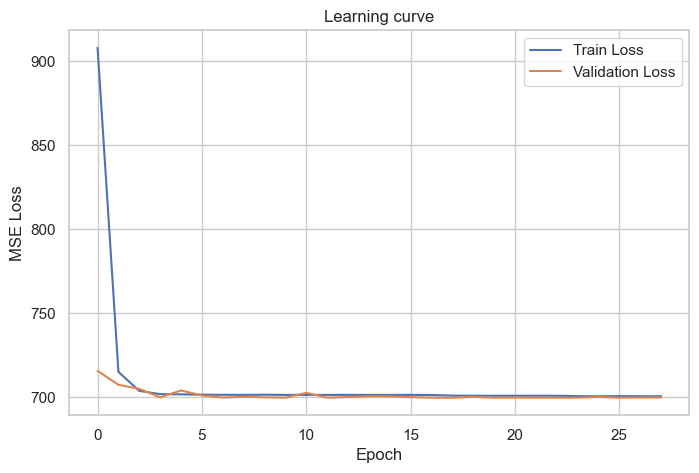

In [20]:
# Definition of the enhanced network
def create_improved_nn(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim,
              kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.2),
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.2),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        Dense(1)  
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

model_10 = create_improved_nn(X_train.shape[1])

# Callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1
)
early_stop = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True, verbose=1
)

# Learning
history = model_10.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[reduce_lr, early_stop],
    verbose=1
)

model_10.features_ = X_sample.columns.tolist()  

# Predictions and metrics
y_pred_nn2 = model_10.predict(X_test).flatten()
rmse_nn2 = np.sqrt(mean_squared_error(y_test, y_pred_nn2))
r2_nn2 = r2_score(y_test, y_pred_nn2)

print("Enhanced Neural Network")
print(f"RMSE : {rmse_nn2:.3f}")
print(f"R²   : {r2_nn2:.4f}")

# Learning curves and loss function
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Learning curve')
plt.legend()
plt.show()

After testing the improved network with L2 regularization, batch normalization, and dropout, which slightly reduced the RMSE to 26.244 but still did not significantly explain the variance in BPM, we moved on to an optimized deep network. The latter increases the depth and width of the layers (256 → 128 → 64 → 128 → 256), while retaining L2 regularization, batch normalization, dropout, and callbacks to adjust the learning rate and stop learning early. The goal is to give the model the maximum ability to capture nonlinear relationships and complex interactions between features, in order to test whether a more ambitious architecture can improve prediction or stabilize learning compared to the previous improved network.

### Model 11: Advanced Deep Neural Networks

c:\Users\alexl\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
6553/6553 ━━━━━━━━━━━━━━━━━━━━ 61s 8ms/step - loss: 1516.2698 - val_loss: 706.2515 - learning_rate: 0.0010
Epoch 2/100
6553/6553 ━━━━━━━━━━━━━━━━━━━━ 50s 8ms/step - loss: 751.5032 - val_loss: 709.9923 - learning_rate: 0.0010
Epoch 3/100
6553/6553 ━━━━━━━━━━━━━━━━━━━━ 50s 8ms/step - loss: 737.0649 - val_loss: 712.8592 - learning_rate: 0.0010
Epoch 4/100
6553/6553 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step - loss: 720.9311 - val_loss: 709.3702 - learning_rate: 0.0010
Epoch 5/100
6553/6553 ━━━━━━━━━━━━━━━━━━━━ 52s 8ms/step - loss: 712.9497 - val_loss: 711.7165 - learning_rate: 0.0010
Epoch 6/100
6553/6553 ━━━━━━━━━━━━━━━━━━━━ 52s 8ms/step - loss: 704.5683 - val_loss: 702.3179 - learning_rate: 0.0010
Epoch 7/100
6553/6553 ━━━━━━━━━━━━━━━━━━━━ 52s 8ms/step - loss: 704.9539 - val_loss: 700.7867 - learning_rate: 0.0010
Epoch 8/100
6553/6553 ━━━━━━━━━━━━━━━━━━━━ 52s 8ms/step - loss: 702.3580 - val_loss: 700.6207 - learning_rate: 0.0010
Epoch 9/100
6553/6553 ━━━━━━━━━━━━━━━━━━━━ 52s 8ms/step

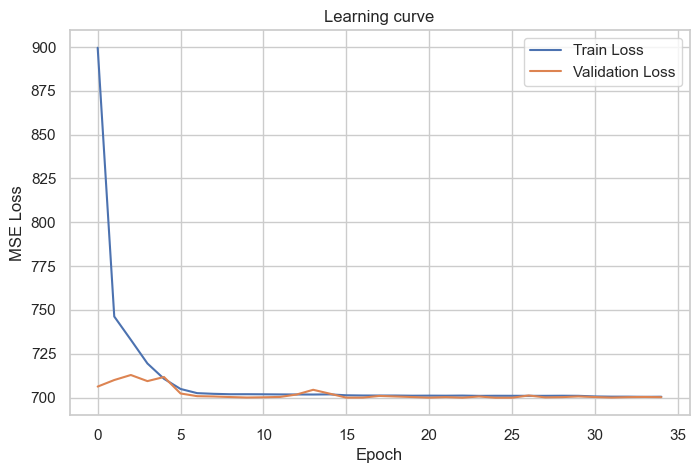

In [21]:
# Advanced Deep Neural Networks
def create_optimized_nn(input_dim):
    model = Sequential([
        Dense(256, activation='relu', input_dim=input_dim,
              kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.2),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.2),
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.2),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.2),
        Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

model_11 = create_optimized_nn(X_train.shape[1])

# Callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1
)
early_stop = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True, verbose=1
)

# Learning
history = model_11.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=64,
    callbacks=[reduce_lr, early_stop],
    verbose=1
)

model_11.features_ = X_sample.columns.tolist()  

# Predictions and metrics
y_pred_nn3 = model_11.predict(X_test).flatten()
rmse_nn3 = np.sqrt(mean_squared_error(y_test, y_pred_nn3))
r2_nn3 = r2_score(y_test, y_pred_nn3)

print("Enhanced Deep Neural Network")
print(f"RMSE : {rmse_nn3:.3f}")
print(f"R²   : {r2_nn3:.4f}")

# Learning curves and loss function
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Learning curve')
plt.legend()
plt.show()

# Synthesis

In [23]:
models_dict = {
    'Model 1: Linear regression all vars': model_1,
    'Model 2: Linear regression explanatory vars': model_2,
    'Model 3: Linear regression feature engineering': model_3,
    'Model 4: Linear regression by cluster': model_4,
    'Model 5: Ridge and Lasso': model_5,
    'Model 6: Random Forest': model_6,
    'Model 7: Gradient Boosting': model_7,
    'Model 9: Neural Networks': model_9,
    'Model 10: Advanced Neural Networks': model_10,
    'Model 11: Advanced Deep Neural Networks': model_11
}

rmse_dict = {
    'Model 1: Linear regression all vars': rmse_mod1,
    'Model 2: Linear regression explanatory vars': rmse_mod2,
    'Model 3: Linear regression feature engineering': rmse_mod3,
    'Model 4: Linear regression by cluster': rmse_mod4,
    'Model 5: Ridge and Lasso': min(rmse_global_ridge, rmse_global_lasso),
    'Model 6: Random Forest': rmse_rf,
    'Model 7: Gradient Boosting': rmse_gb,
    'Model 9: Neural Networks': rmse_nn,
    'Model 10: Advanced Neural Networks': rmse_nn2,
    'Model 11: Advanced Deep Neural Networks': rmse_nn3
}

df_rmse = pd.DataFrame.from_dict(rmse_dict, orient='index', columns=['RMSE'])
df_rmse = df_rmse.sort_values('RMSE')

print("=== Tableau récapitulatif des RMSE ===")
print(df_rmse)

best_model_name = df_rmse.index[0]
best_model_rmse = df_rmse.iloc[0, 0]
best_model = models_dict[best_model_name]

print(f"\nMeilleur modèle : {best_model_name} | RMSE = {best_model_rmse:.3f}")

=== Tableau récapitulatif des RMSE ===
                                                     RMSE
Model 7: Gradient Boosting                      26.439265
Model 3: Linear regression feature engineering  26.443029
Model 1: Linear regression all vars             26.443880
Model 2: Linear regression explanatory vars     26.444325
Model 10: Advanced Neural Networks              26.450849
Model 11: Advanced Deep Neural Networks         26.451139
Model 9: Neural Networks                        26.486546
Model 5: Ridge and Lasso                        26.504229
Model 4: Linear regression by cluster           26.504239
Model 6: Random Forest                          26.569931

Meilleur modèle : Model 7: Gradient Boosting | RMSE = 26.439


We decide to choose Gradient Boosting

# Final Model

Train full : (335464, 9)
Validation : (83867, 9)
Test       : (104833, 9)
Best n_estimators : 219
Best val RMSE     : 26.486

Gradient Boosting (Advanced)
RMSE : 26.495
R²   : 0.0004

Top 15 feature importances:
MoodScore                    0.201958
TrackDurationMs              0.180852
RhythmScore                  0.145756
Energy                       0.140484
VocalContent                 0.089875
LivePerformanceLikelihood    0.073311
AudioLoudness                0.060470
AcousticQuality              0.057070
InstrumentalScore            0.050224
dtype: float64


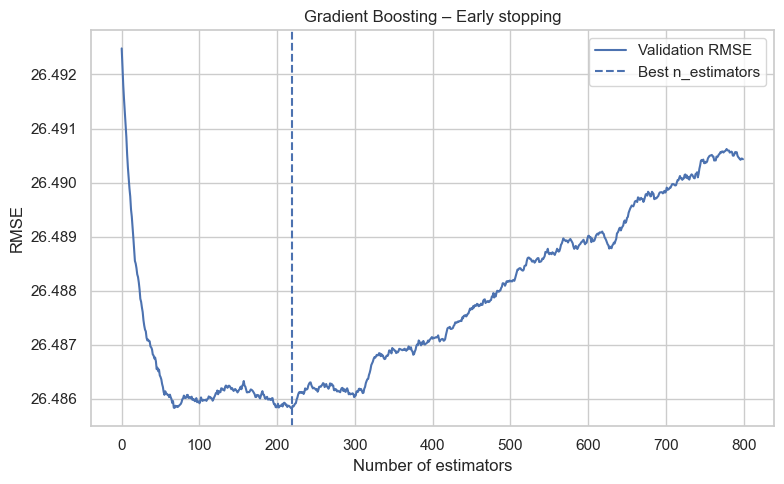

In [24]:
# 1. Split TRAIN / VAL / TEST (stratifié sur y)
# Stratification approximative via quantiles (robuste sur grosses volumétries)
y_bins = pd.qcut(y, q=10, duplicates="drop")

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y_bins
)

# Split validation depuis le train
y_bins_train = pd.qcut(y_train, q=10, duplicates="drop")

X_train_full, X_val, y_train_full, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_bins_train
)

print("Train full :", X_train_full.shape)
print("Validation :", X_val.shape)
print("Test       :", X_test.shape)

# 2. Gradient Boosting optimisé grande échelle
gb_model = GradientBoostingRegressor(
    n_estimators=800,          # volontairement large (early stopping après)
    learning_rate=0.03,
    max_depth=3,               # clé pour gros dataset
    min_samples_leaf=50,       # réduit le bruit
    subsample=0.8,             # bagging-like
    max_features=0.8,          # random subspace
    random_state=42
)

gb_model.fit(X_train_full, y_train_full)

# 3. Early stopping manuel (SUR LA VAL)
val_mse = []

for y_val_pred in gb_model.staged_predict(X_val):
    val_mse.append(mean_squared_error(y_val, y_val_pred))

best_n_estimators = np.argmin(val_mse) + 1
best_rmse_val = np.sqrt(val_mse[best_n_estimators - 1])

print(f"Best n_estimators : {best_n_estimators}")
print(f"Best val RMSE     : {best_rmse_val:.3f}")

# 4. Refit FINAL sur tout le TRAIN
gb_final = GradientBoostingRegressor(
    n_estimators=best_n_estimators,
    learning_rate=0.03,
    max_depth=3,
    min_samples_leaf=50,
    subsample=0.8,
    max_features=0.8,
    random_state=42
)

gb_final.fit(X_train, y_train)
gb_final.features_ = X_sample.columns.tolist()

# 5. Évaluation finale sur TEST
y_pred_gb = gb_final.predict(X_test)

rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)

print("\nGradient Boosting (Advanced)")
print(f"RMSE : {rmse_gb:.3f}")
print(f"R²   : {r2_gb:.4f}")

# 6. Feature importances
gb_importances = pd.Series(
    gb_final.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

print("\nTop 15 feature importances:")
print(gb_importances.head(15))

# 7. Learning curve (validation RMSE)
plt.figure(figsize=(8, 5))
plt.plot(np.sqrt(val_mse), label="Validation RMSE")
plt.axvline(best_n_estimators, linestyle="--", label="Best n_estimators")
plt.xlabel("Number of estimators")
plt.ylabel("RMSE")
plt.title("Gradient Boosting – Early stopping")
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
X_fe = X.copy()

# =========================
# 1. Transformations non linéaires
# =========================
for col in features:
    if (X_fe[col] > 0).all():
        X_fe[f"{col}_log"] = np.log1p(X_fe[col])
        X_fe[f"{col}_sqrt"] = np.sqrt(X_fe[col])

# =========================
# 2. Interactions multiplicatives (limitées)
# =========================
base_feats = features[:min(5, len(features))]

for i in range(len(base_feats)):
    for j in range(i + 1, len(base_feats)):
        f1, f2 = base_feats[i], base_feats[j]
        X_fe[f"{f1}_x_{f2}"] = X_fe[f1] * X_fe[f2]

# =========================
# 3. Ratios
# =========================
for i in range(min(3, len(features))):
    for j in range(i + 1, min(6, len(features))):
        num, den = features[i], features[j]
        X_fe[f"{num}_over_{den}"] = X_fe[num] / (X_fe[den] + 1e-6)

# =========================
# 4. Normalisation relative
# =========================
for col in features:
    mean_val = X_fe[col].mean()
    X_fe[f"{col}_minus_mean"] = X_fe[col] - mean_val
    X_fe[f"{col}_over_mean"] = X_fe[col] / (mean_val + 1e-6)

# =========================
# 5. Rank & quantiles (robustes)
# =========================
for col in features:
    X_fe[f"{col}_rank"] = X_fe[col].rank(pct=True)
    X_fe[f"{col}_qbin"] = pd.qcut(
        X_fe[col],
        q=10,
        labels=False,
        duplicates="drop"
    )

print(f"Features initiales : {len(features)}")
print(f"Features après FE : {X_fe.shape[1]}")

X = X_fe

# Stratification approximative
y_bins = pd.qcut(y, q=10, duplicates="drop")

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y_bins
)

y_bins_train = pd.qcut(y_train, q=10, duplicates="drop")

X_train_full, X_val, y_train_full, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_bins_train
)

print("Train full :", X_train_full.shape)
print("Validation :", X_val.shape)
print("Test       :", X_test.shape)

gb_model = GradientBoostingRegressor(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=3,
    min_samples_leaf=50,
    subsample=0.8,
    max_features=0.8,
    random_state=42
)

gb_model.fit(X_train_full, y_train_full)

val_mse = []

for y_val_pred in gb_model.staged_predict(X_val):
    val_mse.append(mean_squared_error(y_val, y_val_pred))

best_n_estimators = np.argmin(val_mse) + 1
best_rmse_val = np.sqrt(val_mse[best_n_estimators - 1])

print(f"Best n_estimators : {best_n_estimators}")
print(f"Best val RMSE     : {best_rmse_val:.3f}")

gb_final = GradientBoostingRegressor(
    n_estimators=best_n_estimators,
    learning_rate=0.03,
    max_depth=3,
    min_samples_leaf=50,
    subsample=0.8,
    max_features=0.8,
    random_state=42
)

gb_final.fit(X_train, y_train)

# Sauvegarde des features
gb_final.features_ = X_train.columns.tolist()

y_pred_gb = gb_final.predict(X_test)

rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)

print("\nGradient Boosting (Full FE)")
print(f"RMSE : {rmse_gb:.3f}")
print(f"R²   : {r2_gb:.4f}")

gb_importances = (
    pd.Series(gb_final.feature_importances_, index=gb_final.features_)
      .sort_values(ascending=False)
)

print("\nTop 20 feature importances:")
print(gb_importances.head(20))

plt.figure(figsize=(8, 5))
plt.plot(np.sqrt(val_mse), label="Validation RMSE")
plt.axvline(best_n_estimators, linestyle="--", label="Best n_estimators")
plt.xlabel("Number of estimators")
plt.ylabel("RMSE")
plt.title("Gradient Boosting – Early stopping")
plt.legend()
plt.tight_layout()
plt.show()

Features initiales : 9
Features après FE : 83
Train full : (335464, 83)
Validation : (83867, 83)
Test       : (104833, 83)


### Forecast on test file

In [35]:
# 1. Load test file
test_df = pd.read_csv("C:\\Users\\alexl\\Downloads\\test.csv")

# 2. Feature engineering sur test_df (même transformations que sur train)
X_test_fe = test_df[features].copy()

# 2a. Transformations non linéaires
for col in features:
    if (X_test_fe[col] > 0).all():
        X_test_fe[f"{col}_log"] = np.log1p(X_test_fe[col])
        X_test_fe[f"{col}_sqrt"] = np.sqrt(X_test_fe[col])

# 2b. Interactions multiplicatives (limitées aux mêmes colonnes que train)
base_feats = features[:min(5, len(features))]
for i in range(len(base_feats)):
    for j in range(i + 1, len(base_feats)):
        f1, f2 = base_feats[i], base_feats[j]
        X_test_fe[f"{f1}_x_{f2}"] = X_test_fe[f1] * X_test_fe[f2]

# 2c. Ratios
for i in range(min(3, len(features))):
    for j in range(i + 1, min(6, len(features))):
        num, den = features[i], features[j]
        X_test_fe[f"{num}_over_{den}"] = X_test_fe[num] / (X_test_fe[den] + 1e-6)

# 2d. Normalisation relative (train mean utilisé)
for col in features:
    mean_val = X_train[col].mean()  # attention : toujours la moyenne du train
    X_test_fe[f"{col}_minus_mean"] = X_test_fe[col] - mean_val
    X_test_fe[f"{col}_over_mean"] = X_test_fe[col] / (mean_val + 1e-6)

# 2e. Rank & quantiles (approximation)
for col in features:
    X_test_fe[f"{col}_rank"] = X_test_fe[col].rank(pct=True)
    X_test_fe[f"{col}_qbin"] = pd.qcut(
        X_test_fe[col],
        q=10,
        labels=False,
        duplicates="drop"
    )

# 3. Prédictions
test_df["y_pred_gb"] = gb_final.predict(X_test_fe)

print(test_df[["y_pred_gb"]].head())


    y_pred_gb
0  118.782780
1  118.922436
2  118.913567
3  119.004286
4  118.750101


## Creating submission

In [ ]:

submission = pd.DataFrame({
    "Id": test_df.index,          
    "Prediction": y_test_pred
})

submission.to_csv("submission.csv", index=False)

print("\nsubmission.csv généré avec succès.")